# Analyse des données relatives à la dystrophie de Fuchs

Dystrophie des cellules endotheliales) impliqués dans la maintenance et l'hydratation de la cornée. Dans le cas de stade avancé la chirurgie consistant en un remplacement de l'endothelium permet la restauration de l'hydratation physiologique du stroma (et de la transparence). Dans certains cas une **fibrose sous épitheliale** est observée et celle ci ne **se resorbe pas** même après chirurgie, contrairement aux fibroses sous épithéliales résultant d'une chirurgie de la cornée pour la correction de l'acuitée visuelle.

A travers cette annalyse on s'interresse donc aux résultats de la chirurgie de dystrophie de Fuchs, notamment pour voir si des fibroses sont observés. 

## Chargement de la base de données

On récupère trois dataset d'images pré-traités, c'est à dite étant passé par le processus de quantification des la ligne sous épithéliale (ligne de Bowman pour les cornés saines, fibrose pour les cornées pathologiques):
- data_healthy: Dataframe d'image de cornées saines
- data_fuchs: Dataframe d'image de cornées atteitens par une distrophie de Fuchs avant (Month=0) et après (Month>0) chirurgie correctrice.
- data_learning: Dataframe constitué de cornées saines et de cornées ayant subit une chirurgie pour la correction de l'acuité visuelle résultatn en l'apparition d'une fibrose sous épithéliale.


In [9]:
from src.image_OCT import *
from src.image_Quantification import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate
import os
from os import listdir
from os.path import isfile, join
import re
import pandas as pd
import math 
import seaborn as sns
from sklearn import datasets, svm

# Extraction of already saved pre-treated data: 
data_healthy = pd.read_pickle("./Dataset/data_set_healthy_2.pkl")
data_fuchs = pd.read_pickle("./Dataset/data_set_fuchs_2.pkl")          #/!\
data_learning = pd.read_pickle("./Dataset/data_set_learning_small_2.pkl")

# Adding for the Fuchs dataset the time
month=np.ones(len(data_fuchs))*np.nan
id=[]
type=[]
for i in range(len(data_fuchs)):
    origin=data_fuchs["Origin"][i]
    origin_split=origin.split("_")
    month[i]=int(origin_split[2])
    id.append(origin_split[0]+"_"+origin_split[1])
    type.append(origin_split[3])
id=np.array(id)
type=np.array(type)
data_fuchs=data_fuchs.assign(Month=month)
data_fuchs=data_fuchs.assign(Id=id)
data_fuchs=data_fuchs.assign(Type=type)
data_fuchs.to_pickle("./Dataset/data_set_fuchs.pkl")

# Display Dataframe
data_fuchs

,PeakWidth,Sigma,DataCov,Mean,MSE,AreaRatio,FibrosisUnderBowman,Healthy,Origin,Month,Id,Type
0,2.769444,0.147228,0.000120,0.305218,0.193319,-0.002694,True,2,BARVER_OD_0_Line,0.0,BARVER_OD,Line
1,3.000231,0.141357,0.000185,0.346134,0.182483,-0.001856,True,2,BARVER_OD_0_Pachy,0.0,BARVER_OD,Pachy
2,2.769444,0.640778,0.004447,1.272999,0.127240,0.056221,False,2,BARVER_OD_12_Line,12.0,BARVER_OD,Line
3,1.384722,0.260465,0.000989,0.767539,0.011497,0.012825,False,2,BARVER_OD_12_Pachy,12.0,BARVER_OD,Pachy
4,2.307870,0.522643,0.003247,1.038623,0.061781,0.023608,False,2,BARVER_OD_1_Line,1.0,BARVER_OD,Line
...,...,...,...,...,...,...,...,...,...,...,...,...
299,1.846296,0.493319,0.000048,1.045214,0.014399,0.004149,False,2,VANMAR_OD_0_Pachy,0.0,VANMAR_OD,Pachy
300,6.923610,0.250252,0.000077,0.524463,0.458654,-0.015062,True,2,WEIELI_OS_0_Line,0.0,WEIELI_OS,Line
301,2.776492,0.544895,0.000839,1.391041,0.028198,0.026215,False,2,WEIELI_OS_0_PachyWide,0.0,WEIELI_OS,PachyWide
302,3.461805,0.695550,0.001855,1.193527,0.114862,0.016264,True,2,WEIELI_OS_9_Line,9.0,WEIELI_OS,Line


## Représentation des données

En représentant temporellement les données des images issues de cornée atteintes de la distrophie de Fuchs on remarque temporellement peu de changements sur les quantificateurs confirmant une globale invariance entre les fibroses pré et post chirurgie. A l'exeception d'un outlier.

In [10]:
id_list=np.unique(data_fuchs["Id"])
target_type="Pachy"
quantifier="Mean"
values=[]
for id in id_list:
    positions=np.where(data_fuchs["Id"]==id)[0]
    positions=positions[np.where(data_fuchs["Type"][positions]==target_type)[0]]
    subdata=(data_fuchs.T[positions]).T
    arg=np.array(np.argsort(subdata["Month"]))
    arg=positions[arg]
    # print("Arg",arg,"*")
    if len(arg)>=3:
        # print(subdata["Month"])
        X=np.array(subdata["Month"][arg].T)
        Y=np.array(subdata[quantifier][arg].T)
        ids=np.array(subdata["Id"][arg].T)
        value={
            "Months":X,
            "Sigmas":Y,
            "Id":ids[0]
        }
        values.append(value)
data_Line_time=pd.DataFrame(values) 

Nulmber of patients:28


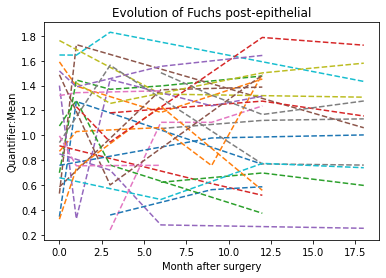

In [11]:
print("Nulmber of patients:"+str(len(data_Line_time)))
for i in range(len(data_Line_time)):
	plt.plot(data_Line_time["Months"][i],data_Line_time["Sigmas"][i],'--',label=data_Line_time["Id"][i])
plt.xlabel("Month after surgery")
plt.ylabel("Quantifier:"+quantifier)
plt.title("Evolution of Fuchs post-epithelial")
plt.show()

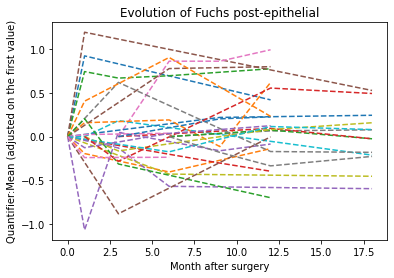

In [12]:
for i in range(len(data_Line_time)):
	plt.plot(data_Line_time["Months"][i],data_Line_time["Sigmas"][i]-data_Line_time["Sigmas"][i][0],'--',label=data_Line_time["Id"][i])
plt.xlabel("Month after surgery")
plt.ylabel("Quantifier:"+quantifier+" (adjusted on the first value)")
plt.title("Evolution of Fuchs post-epithelial")
plt.show()

## Comparaison des tailles caratéristiques des quantificateurs en fonction de l'état de la cornée


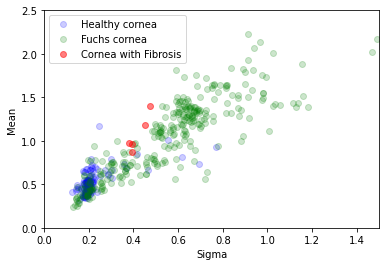

In [13]:
plt.figure()
plt.plot(data_healthy['Sigma'],data_healthy['Mean'],'o',color="blue",alpha=0.2,label="Healthy cornea")
plt.plot(data_fuchs['Sigma'],data_fuchs['Mean'],'o',color="green",alpha=0.2,label="Fuchs cornea")
plt.plot(data_learning['Sigma'][data_learning['Healthy']==0],data_learning['Mean'][data_learning['Healthy']==0],'o',color="red",alpha=0.5,label="Cornea with Fibrosis")
plt.ylim([0,2.5])
plt.xlim([0,1.5])
plt.xlabel("Sigma")
plt.ylabel("Mean")
plt.legend()
plt.show()

C:\Users\csoub\AppData\Local\Temp/ipykernel_3812/2223169795.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_distrib1=data_fuchs[data_fuchs['Sigma']<0.3][data_fuchs['Mean']<0.75]
C:\Users\csoub\AppData\Local\Temp/ipykernel_3812/2223169795.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_distrib2=data_fuchs[data_fuchs['Sigma']>0.6][data_fuchs['Mean']>1]


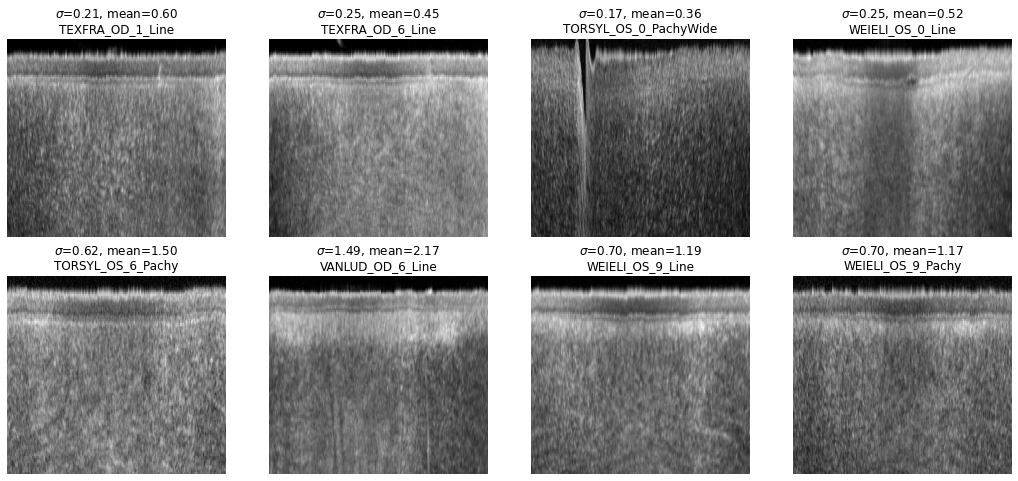

In [15]:
df_distrib1=data_fuchs[data_fuchs['Sigma']<0.3][data_fuchs['Mean']<0.75]
df_distrib2=data_fuchs[data_fuchs['Sigma']>0.6][data_fuchs['Mean']>1]

plt.figure(figsize=(18,8))
dirname = os.getcwd()
figNb=4

for i,name in enumerate(df_distrib1.tail(figNb)['Origin']):
	filepathname=os.path.join(dirname, 'Data\Fuchs_2\\',name+'.jpg')
	im=image_OCT(filepathname)
	im.AutoTreatment()
	plt.subplot(2,figNb,i+1)
	intentityProfile=np.mean(im.OCT_flat,1)
	indexMax=np.argmax(intentityProfile)
	peak=argrelextrema(intentityProfile, np.greater)
	npeak1=np.unique(np.where(peak >= indexMax, peak,indexMax)[0])
	# print(npeak1[0])
	plt.imshow(im.OCT_flat[npeak1[0]-10:npeak1[0]+100,:],cmap="gray",aspect="auto")
	plt.axis('off')
	im_Q=image_Quantification_2(im,intensity_corr=True)
	plt.title(("$\sigma$={:.2f}, mean={:.2f}\n"+name).format(im_Q.parameters['Sigma'],im_Q.parameters['Mean']))
for i,name in enumerate(df_distrib2.tail(figNb)['Origin']):
	filepathname=os.path.join(dirname, 'Data\Fuchs_2\\',name+'.jpg')
	im=image_OCT(filepathname)
	im.AutoTreatment()
	plt.subplot(2,figNb,i+1+figNb)
	intentityProfile=np.mean(im.OCT_flat,1)
	indexMax=np.argmax(intentityProfile)
	peak=argrelextrema(intentityProfile, np.greater)
	npeak1=np.unique(np.where(peak >= indexMax, peak,indexMax)[0])
	# print(npeak1[0])
	plt.imshow(im.OCT_flat[npeak1[0]-10:npeak1[0]+100,:],cmap="gray",aspect="auto")
	plt.axis('off')
	im_Q=image_Quantification_2(im,intensity_corr=True)
	plt.title(("$\sigma$={:.2f}, mean={:.2f}\n"+name).format(im_Q.parameters['Sigma'],im_Q.parameters['Mean']))


In [16]:
from src.image_Quantification_2 import *
def create_new_dataset_2(repository,healthy_value):
	files = [f for f in listdir(repository) if isfile(join(repository, f))]
	quantification=[]
	i=0
	i_list=[]
	for f in files:
		if(f[-3:]=="jpg"):
			i+=1
			try:
				im=image_OCT(os.path.join(repository, f))
			except:
				print("Error with: "+f+" image #"+str(i))
			try:
				im.AutoTreatment()
				im_Q=image_Quantification_2(im,intensity_corr=True)
				parameters=im_Q.parameters
				parameters["Healthy"]=healthy_value
				parameters["Origin"]=f[:-4]
				quantification.append(parameters)
				# print(i,":",healthy)
				i_list.append(i)
			except:
				1+1
				# print("Error with: "+f+" image #"+str(i))
	n=len(quantification)
	print(n,"/",len(files)," files succesfully quantified")
	data=pd.DataFrame(quantification,index=range(n)) 
	return(data)

repertory_fuchs=os.path.join(dirname, 'Data','Fuchs_2')
# repertory_fuchs=os.path.join(dirname, 'Data','Fuchs_renammed')
healthy_value=2 #fushs

data_fuchs_fibrosis_under=create_new_dataset_2(repertory_fuchs,healthy_value)
data_fuchs_fibrosis_under

Error with: HADBER_OS_0_Line.jpg image #146
Error with: OTTCLA_OD_0_Line.jpg image #235
Error with: STECHA_OS_0_Line.jpg image #279
304 / 316  files succesfully quantified


,PeakWidth,Sigma,DataCov,Mean,MSE,AreaRatio,FibrosisUnderBowman,Healthy,Origin
0,2.769444,0.147228,0.000120,0.305218,0.193319,-0.002694,True,2,BARVER_OD_0_Line
1,3.000231,0.141357,0.000185,0.346134,0.182483,-0.001856,True,2,BARVER_OD_0_Pachy
2,2.769444,0.640778,0.004447,1.272999,0.127240,0.056221,False,2,BARVER_OD_12_Line
3,1.384722,0.260465,0.000989,0.767539,0.011497,0.012825,False,2,BARVER_OD_12_Pachy
4,2.307870,0.522643,0.003247,1.038623,0.061781,0.023608,False,2,BARVER_OD_1_Line
...,...,...,...,...,...,...,...,...,...
299,1.846296,0.493319,0.000048,1.045214,0.014399,0.004149,False,2,VANMAR_OD_0_Pachy
300,6.923610,0.250252,0.000077,0.524463,0.458654,-0.015062,True,2,WEIELI_OS_0_Line
301,2.776492,0.544895,0.000839,1.391041,0.028198,0.026215,False,2,WEIELI_OS_0_PachyWide
302,3.461805,0.695550,0.001855,1.193527,0.114862,0.016264,True,2,WEIELI_OS_9_Line


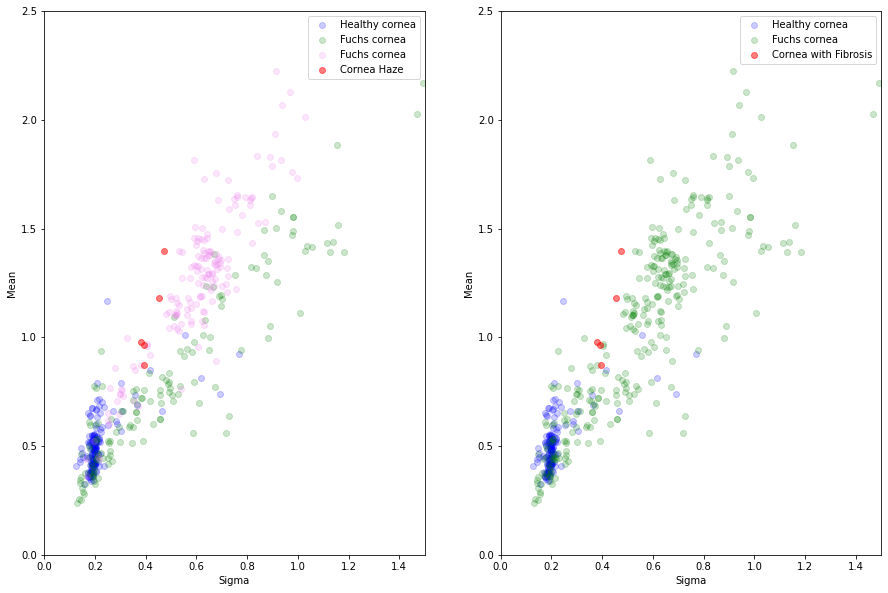

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.plot(data_healthy['Sigma'],data_healthy['Mean'],'o',color="blue",alpha=0.2,label="Healthy cornea")
boolFibrosis=1*data_fuchs_fibrosis_under['FibrosisUnderBowman']
plt.plot(data_fuchs_fibrosis_under['Sigma'][boolFibrosis==1],data_fuchs_fibrosis_under['Mean'][boolFibrosis==1],'o',color="green",alpha=0.2,label="Fuchs cornea")
plt.plot(data_fuchs_fibrosis_under['Sigma'][boolFibrosis==0],data_fuchs_fibrosis_under['Mean'][boolFibrosis==0],'o',color="violet",alpha=0.2,label="Fuchs cornea")

plt.plot(data_learning['Sigma'][data_learning['Healthy']==0],data_learning['Mean'][data_learning['Healthy']==0],'o',color="red",alpha=0.5,label="Cornea Haze")
plt.ylim([0,2.5])
plt.xlim([0,1.5])
plt.xlabel("Sigma")
plt.ylabel("Mean")
plt.legend()
# plt.show()

plt.subplot(122)
plt.plot(data_healthy['Sigma'],data_healthy['Mean'],'o',color="blue",alpha=0.2,label="Healthy cornea")
plt.plot(data_fuchs['Sigma'],data_fuchs['Mean'],'o',color="green",alpha=0.2,label="Fuchs cornea")
plt.plot(data_learning['Sigma'][data_learning['Healthy']==0],data_learning['Mean'][data_learning['Healthy']==0],'o',color="red",alpha=0.5,label="Cornea with Fibrosis")
plt.ylim([0,2.5])
plt.xlim([0,1.5])
plt.xlabel("Sigma")
plt.ylabel("Mean")
plt.legend()
plt.show()